# BERT base uncased MASK ALL usando TUDO
# mascarando o padrão e a sentença toda
## dissertação

# DEV datasets
### HypeNet - DEV
 - 49475 pares
    - True: 20.095% - 9942
    - False: 79.905% - 39533

In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import pandas as pd
import numpy as np
sys.path.append("/home/gabrielescobar/hyper_bert")
import nb_utils
sns.set(style="whitegrid", font_scale=1.5)
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
local = False

In [2]:
# server
# bert DEV en
if local:
    path_file_bert = "../../aaaaaaaa/test-mask-pattern/Weeds.json"
else:
    bert_mask = "../../en-model/bert-base-uncased_bert_score_2020-11-11_20:24:14_HypeNet_train/HypeNet_train.json"
    bert_mask_all = "../../en-model/bert-base-uncased_bert_score_maskall_2021-03-22_23:29:19/train/HypeNet_train.json"
    # alterar
    bert_mask_all_logsoftmax = "../../en-model/bert-base-uncased_bert_score_maskall_2021-03-23_12:26:19/HypeNet_test.json"

dfs_data = {}
dfs_data['mask'] = nb_utils.create_dataframe(json.load(open(path_file_bert)), separator="\t")
dfs_data['maskAll'] = nb_utils.create_dataframe_maskAll(json.load(open(path_file_bert)), separator="\t")
dfs_data['maskAll_LogSoft'] = nb_utils.create_dataframe_maskAll_pattern(json.load(open(path_file_bert)), separator="\t")

pattern_unique = dfs_data['mask']['pattern'].unique().tolist()
len_total_unique = dfs_data['mask']['len_total'].unique().tolist()

for mask_type, value in dfs_data.items():
    print(f"Mask= {mask_type} - DF all with OOV = {value[value['pattern'] == pattern_unique[0]].count()['hiponimo']}")

print("Processamento DEV pronto!")

Número máximo de pares por comprimento= 1095
DF all with OOV = 2233
Processamento DEV pronto!


### DEV - inglês
#### Stats
 - Eixo X: Comprimento do par
 - Eixo Y: Quantidade de pares por comprimento

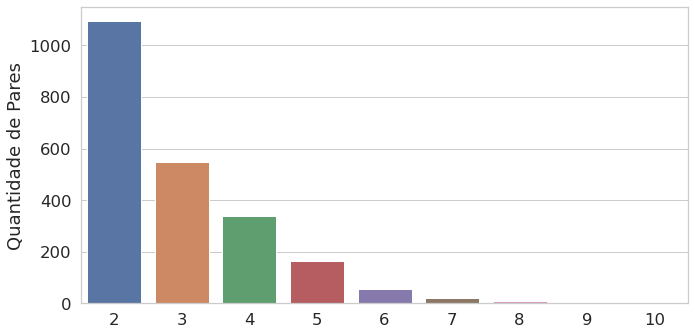

In [3]:
# Balanceamento quantidade de pares por comprimento
# Balanceamento df_with_oov
sns.set(style="whitegrid", font_scale=1.5)


plt.figure(figsize=(10, 5))
df_with_oov_ratio = nb_utils.balanceamento(df_with_oov, patterns=pattern_unique,len_size=len_total_unique)
df_with_oov_ratio['total'] = df_with_oov_ratio['true'] + df_with_oov_ratio['false']
ax = sns.barplot(x="len_total", y="total", data=df_with_oov_ratio)
ax.set(xlabel="")
# ax.set_title(f"Number of pairs")
ax.set(ylabel="Quantidade de Pares")
# plt.savefig('DEV_numero_de_pares_por_comprimento_dataset_ingles.pdf')
plt.show()

### DEV - inglês
#### AP por padrão. Usado para selecionar os melhores padrões
#### Score é BERT dos tokens do padrão

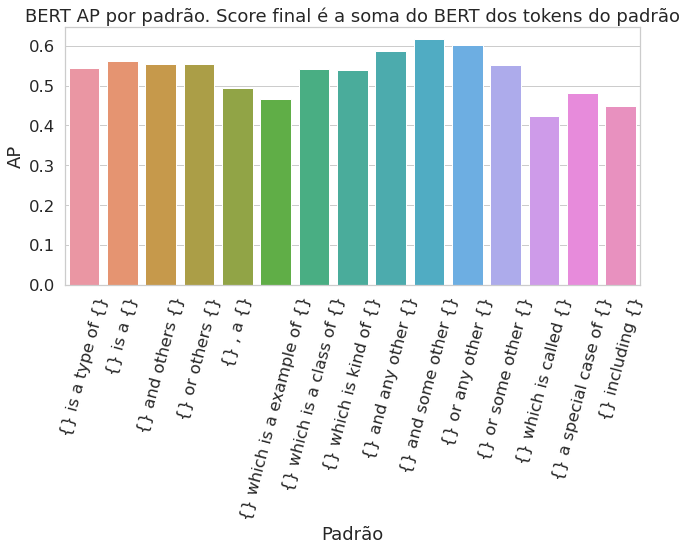

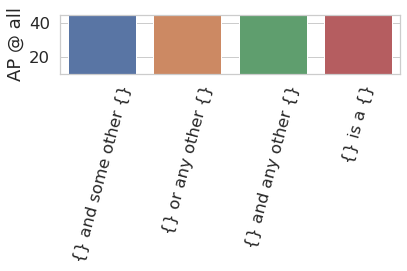

Melhores padrões usando BERT token pattern
['{} and some other {}', '{} or any other {}', '{} and any other {}', '{} is a {}', '{} or others {}', '{} and others {}', '{} or some other {}', '{} is a type of {}', '{} which is a class of {}', '{} which is kind of {}', '{} , a {}', '{} a special case of {}', '{} which is a example of {}', '{} including {}', '{} which is called {}']


In [4]:
# AP por padrao DEV en
# AP por padrão
# IMPORTANTE mudar o key_sort
df_plot = nb_utils.compute_dataframe_AP_by_pattern(df_with_oov, key_sort="score_pattern_mean", pattern_list=pattern_unique)
plt.figure(figsize=(10, 8))
ax = sns.barplot(data=df_plot, x='padrao', y='AP')
ax.set(xlabel="Padrão")
ax.set_title(f"BERT AP por padrão. Score final é a soma do BERT dos tokens do padrão")
plt.xticks(rotation=75)
plt.show()

plt.figure()
df_dissertacao = df_plot.sort_values(by="AP", ascending=False)
df_dissertacao = df_dissertacao.iloc[:4]
df_dissertacao['AP'] = df_dissertacao['AP'] * 100
ax = sns.barplot(data=df_dissertacao, x='padrao', y='AP')
ax.set(ylim=(10, 45))
ax.set(xlabel="")
ax.set(ylabel="AP @ all")
plt.xticks(rotation=75)
# plt.savefig('DEV_EN_4_melhores_padroes.pdf')
plt.show()

print(f"Melhores padrões usando BERT token pattern")
best_pattern_logz = df_plot.sort_values(by='AP', ascending=False)['padrao'].tolist()
print(best_pattern_logz)

### DEV - inglês
#### AP variando os N melhores padrões, usando Average Rank e Min Rank
#### Score é BERT token pattern


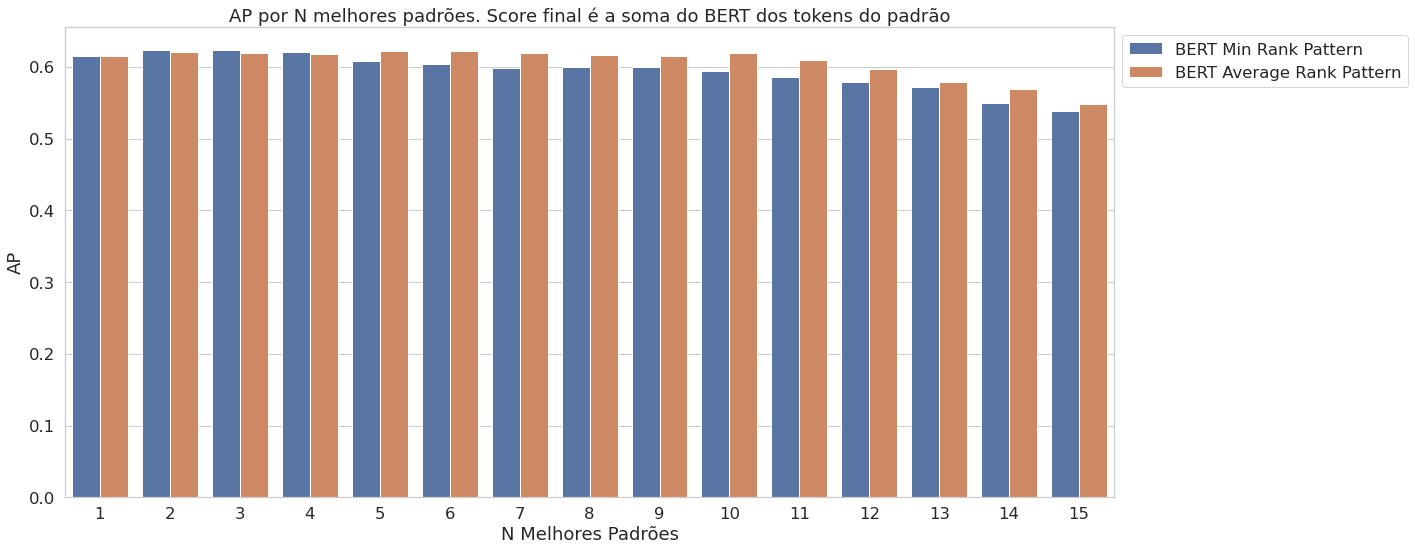

In [5]:
# AP por N melhores padroes DEV EN
# AP por n-rank
df_plot = nb_utils.compute_AP_n_best_pattern(df_with_oov, key_sort="score_pattern_mean", n_best_pattern=best_pattern_logz)
df_plot['method_format'] = df_plot['method'].map(nb_utils.get_method_name_ijcai())
plt.figure(figsize=(20, 8))
ax = sns.barplot(data=df_plot, x='n_best_pattern', y='AP', hue='method_format')
ax.set(xlabel="N Melhores Padrões")
ax.set_title(f"AP por N melhores padrões. Score final é a soma do BERT dos tokens do padrão")
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

### DEV - Inglês
#### Dados do gráfico acima, para visualização em números

In [6]:
# Dados dos gŕaficos acima.
df_mean = df_plot[df_plot['method'] == 'mean score_pattern_mean']
df_mean = df_mean.sort_values(by='AP', ascending=False)
print(f"Melhor combinação de Melhores Padrões usando Média dos ranks entre eles")
print(df_mean.iloc[:4])

print(f"Melhor combinação de Melhores Padrões usando Minimo dos ranks entre eles")
df_min = df_plot[df_plot['method'] == 'min score_pattern_mean']
df_min = df_min.sort_values(by='AP', ascending=False)
print(df_min.iloc[:4])

Melhor combinação de Melhores Padrões usando Média dos ranks entre eles
    n_best_pattern                   method        AP  \
9                5  mean score_pattern_mean  0.622126   
11               6  mean score_pattern_mean  0.622073   
3                2  mean score_pattern_mean  0.621108   
5                3  mean score_pattern_mean  0.619102   

                method_format  
9   BERT Average Rank Pattern  
11  BERT Average Rank Pattern  
3   BERT Average Rank Pattern  
5   BERT Average Rank Pattern  
Melhor combinação de Melhores Padrões usando Minimo dos ranks entre eles
   n_best_pattern                  method        AP          method_format
2               2  min score_pattern_mean  0.624240  BERT Min Rank Pattern
4               3  min score_pattern_mean  0.623925  BERT Min Rank Pattern
6               4  min score_pattern_mean  0.620373  BERT Min Rank Pattern
0               1  min score_pattern_mean  0.615811  BERT Min Rank Pattern


In [7]:
# Balanceamento true/false
# balanceamento do dataset inteiro
df_size = nb_utils.balanceamento_all(df_with_oov, patterns=pattern_unique)
print(df_size)

         true       false  total
0  1119.00000  1114.00000   2233
1     0.50112     0.49888      1


In [8]:
%reset_selective -f json_
%reset_selective -f ax
%reset_selective -f path

----------------

# Datasets Test - 10 datasets em inglês
### Usando os 4 melhores padrões do HypeNet-train

In [9]:
# processo demorado
if local:
    path_json_normal = "../../aaaaaaaa/test-mask-pattern/"
else:
    path_json_normal = "../../en-model/bert-base-uncased_bert_score_maskall_2021-03-22_23:29:19"

dfs = {}
pattern_unique = {}
filename = ""
for filename in os.listdir(path_json_normal):
    if os.path.isfile(os.path.join(path_json_normal, filename)) and filename.endswith(".json"):
        df = nb_utils.create_dataframe_maskAll_pattern(json.load(open(os.path.join(path_json_normal, filename))), separator="\t")
        df['tipo'] = 'normal'
        dfs[filename + " normal"] = df
pattern_unique['normal'] = df['pattern'].unique().tolist()
len_total_unique = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
pattern_unique = pattern_unique['normal']

df_ratios = []
for dataset_name in dfs.keys():
    print(dataset_name)
    dname, type_dataset = dataset_name.split()
    df_ratio = nb_utils.balanceamento(dfs[dataset_name], len_size=len_total_unique,
                                      patterns=pattern_unique)
    df_ratio['dataset'] = dname
    df_ratio['tipo'] = type_dataset
    df_ratios.append(df_ratio)
df_ratios = pd.concat(df_ratios, ignore_index=True)
print("Processamento pronto")

levy2014.json normal
Balanceamento: [1, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] não está no dataframe!
turney2014.json normal
Balanceamento: [1, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] não está no dataframe!
Weeds.json normal
Balanceamento: [1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] não está no dataframe!
BLESS.json normal
Balanceamento: [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] não está no dataframe!
wordnet_test.json normal
Balanceamento: [1, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] não está no dataframe!
HypeNet_test.json normal
Balanceamento: [1, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] não está no dataframe!
Processamento pronto


### Test - inglês 10 datasets
#### Stats
 - Eixo X: Comprimento do par
 - Eixo Y: Porcentagem de pares verdadeiros para cada comprimento
 - OBS: Eixo Y não é compartilhado, para facilitar a visualização


In [10]:
df_ratios['dataset_format'] = df_ratios['dataset'].map(nb_utils.get_dataset_names())
df_ratios['dataset_tipo'] = df_ratios['dataset_format'] + " " + df_ratios['tipo']
df_ratios['ratio_percent'] = df_ratios['ratio'] * 100
df_ratios['total'] = df_ratios['true'] + df_ratios['false']
df_plot_lensubtoken = df_ratios[df_ratios['tipo'] == 'normal']

In [11]:
# best_pattern_train = ['{} is a {}', '{} or some other {}', '{} and some other {}', '{} or any other {}', '{} , a {}', '{} which is a class of {}', '{} is a type of {}', '{} and any other {}', '{} or others {}', '{} and others {}', '{} which is kind of {}', '{} including {}', '{} a special case of {}', '{} which is a example of {}', '{} which is called {}']
best_pattern_train = best_pattern_logz
df_en = []
dfs2 = []
# best_pattern_train = nb_utils.best_pattern_HypeNet_train_logz
# seleciona o número de melhores pares para calcular o AP
best_pattern_num_train = 4
for count_best_pattern in range(1, best_pattern_num_train + 1):
    for dataset_name in dfs.keys():
        dname, type_dataset = dataset_name.split()
        # type_dataset == 'logZ', 'randomLogZ', 'normal'
        if type_dataset == 'normal':
            df_temp= nb_utils.compute_min_mean_ap_normal(dfs[dataset_name],
                pattern_list=best_pattern_train, dataset_name=dname, best_pattern_num=count_best_pattern)
            df_temp['tipo'] = type_dataset
            df_temp['pattern_num'] = count_best_pattern
            dfs2.append(df_temp)
            # df_temp = nb_utils.compute_ap_bert_soma(dfs[dataset_name], pattern_list=best_pattern_train, dataset_name=dname,
            #                                         best_pattern_num=count_best_pattern, tipo='normal', column_sort="score_pattern_mean")
            # df_temp['tipo'] = "normal"
            # df_temp['pattern_num'] = count_best_pattern
            # dfs2.append(df_temp)
df_en = pd.concat(dfs2)
df_en = df_en[df_en['method'].isin(['min score_pattern_mean', 'mean score_pattern_mean'])]

Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)
Não tem como usar score_final_log(z)


### Test
### AP para cada método (BERT, DIVE e Word2vec)
#### Usando BERT - Log(Z) e BERT - Log(Z) random pairs
 - BERT com e sem Log(Z)
 - Ordem dos algoritmo na legenda:
    - BERT Min rank Log(Z)
    - BERT Average rank Log(Z)
    - BERT Min rank
    - BERT Average rank
    - BERT Min rank Log(Z) - Random pairs
    - BERT Average rank Log(Z) - Random pairs
    - Word2vec C
    - DIVE DeltaS * C

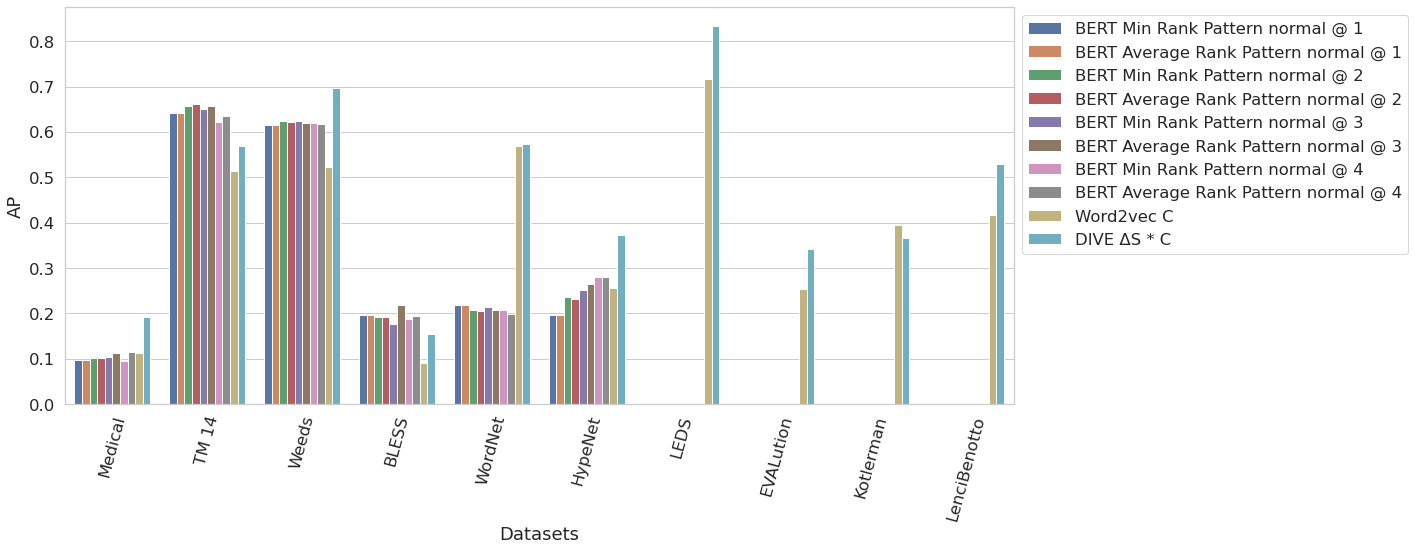

<Figure size 1440x576 with 0 Axes>

/home/gabrielescobar/anaconda3/envs/hyper_bert/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


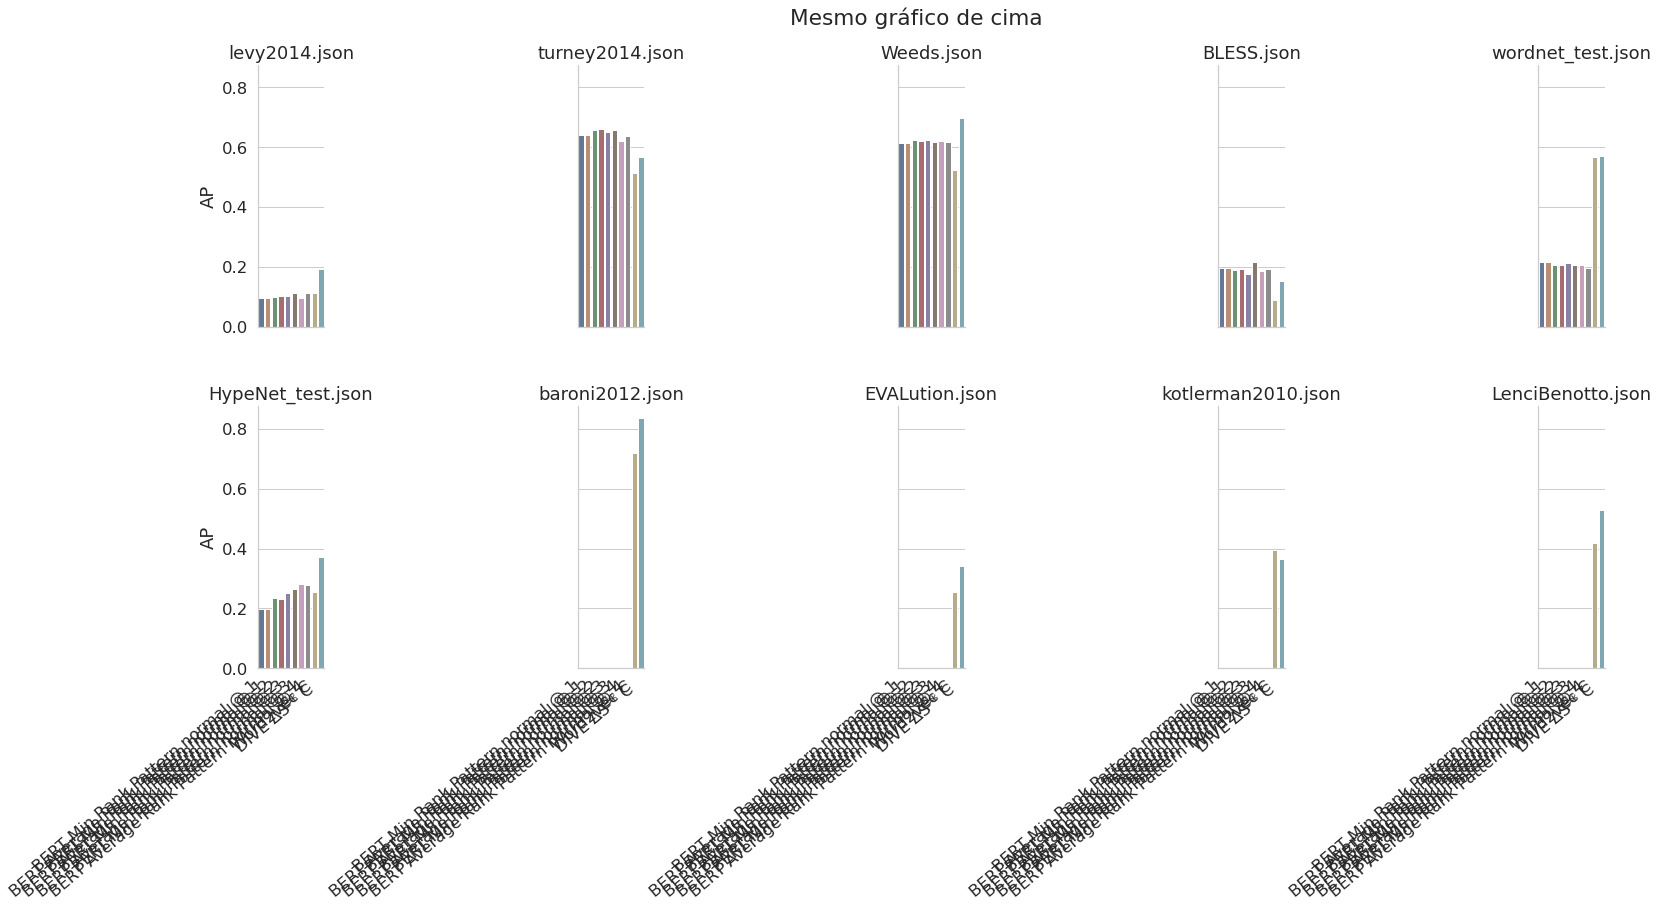

In [12]:
df_dive = nb_utils.get_df_dive()
df_dive['method_format_tipo'] = df_dive['method'].map(nb_utils.get_method_name_ijcai())

#pegar apenas BERT e Dive/w2v
# normal == bert
# logZ == bert - logZ
df_dissertacao = df_en.copy()

# AP por método
df_dissertacao['method_format_tipo'] = df_dissertacao['method_format'].map(nb_utils.get_method_name_ijcai())
df_dissertacao['method_format_tipo'] += " " + df_dissertacao['tipo'] 
df_dissertacao['method_format_tipo'] += " @ " + df_dissertacao['pattern_num'].astype('str')
# print(df_dissertacao['method_format_tipo'])

df_dissertacao = pd.concat([df_dissertacao, df_dive])
df_dissertacao['dataset_format'] = df_dissertacao['dataset'].map(nb_utils.get_dataset_names())
plt.figure(figsize=(20,8))
ax = sns.barplot(x='dataset_format' ,hue="method_format_tipo", y="AP", ci="sd",data=df_dissertacao)
ax.set(xlabel="Datasets")
# ax.set_title(f"AP nos datasets, cada dataset usa combinações geradas usando os {best_pattern_num_train} melhores"
#              f" padrões do DEV")
ax.legend(bbox_to_anchor=(1, 1))
legend = ax.get_legend()
_ = plt.xticks(rotation=75)
# plt.savefig('fig_ap_datasetsEn_p2.pdf')
plt.show()


plt.figure(figsize=(20,8)) # this creates a figure 8 inch wide, 4 inch high
g = sns.catplot(x="method_format_tipo", y="AP", col="dataset", col_wrap=5,
                data=df_dissertacao, saturation=.5,
                kind="bar", ci="sd", aspect=.9, legend='full')
(g.set_axis_labels("", "AP")
    .set_xticklabels(rotation=40, ha="right")
    .set_titles("{col_name}"))
plt.subplots_adjust(top=0.9, hspace=0.3)
_ = g.fig.suptitle('Mesmo gráfico de cima')
plt.show()

### Test - inglês 10 datasets
#### Stats
 - Dados dos gráficos acima para exportar e vizualizar

In [13]:
# dados dos graficos acima
# salvar CSV e fazer rank medio dos métodos
# print contagem
df_print = df_ratios.groupby(['dataset', 'tipo']).sum()[['true', 'false', 'total']]
df_print['ratio'] = df_print['true'] / df_print['total']
print(df_print)
#
# # df to csv
# df_dissertacao['dataset_format'] = df_dissertacao['dataset'].map(nb_utils.get_dataset_names())
# group_list = ['dataset_format', 'AP', 'tipo','method_format_tipo', 'N', 'hyper_num', 'pattern_num']
# methods_avg_list = ['BERT Min Rank Pattern @ 1', 'BERT Average Rank Pattern @ 1',
#                     'BERT Min Rank log(Z) logZ @ 2', 'BERT Average Rank log(Z) logZ @ 2',
#                     'BERT Min Rank log(Z) logZ @ 3', 'BERT Average Rank log(Z) logZ @ 3',
#                     'BERT Min Rank log(Z) logZ @ 4', 'BERT Average Rank log(Z) logZ @ 4',
#                     'Word2vec C', 'DIVE ΔS * C ']
#
#
# df_csv = df_dissertacao[group_list]
# df_csv = df_csv.sort_values(by=group_list[:2])
# df_csv['AP'] = df_csv['AP'] * 100
# df_csv['AP'] = df_csv['AP'].round(2)
# # print(df_csv[df_csv['dataset_format'] == "Medical"])
# table = pd.pivot_table(df_csv, values='AP', index="dataset_format", columns=['method_format_tipo'])
# # print(table)
# tableT = table.copy()
# # tableT = tableT.set_index('dataset_format')
# tableT = tableT[methods_avg_list]
# tableT = tableT.T
# rank = pd.DataFrame()
# for c in tableT.columns:
#     rank[c] = tableT[c].rank(method="min", ascending=False)
# rank['avg'] = rank.mean(axis=1)
# rank = rank.sort_index()
# table.to_csv("datasets_ingles_bert_dive_word2vec_4_padroes_maskall",index=True)
# rank.to_csv("datasets_ingles_bert_dive_word2vec_4_padroes_maskall_AVG",index=True)

                          true  false  total     ratio
dataset           tipo                                
BLESS.json        normal  1337  25195  26532  0.050392
HypeNet_test.json normal  3512  14158  17670  0.198755
Weeds.json        normal  1119   1114   2233  0.501120
levy2014.json     normal   945  11657  12602  0.074988
turney2014.json   normal  1058   1100   2158  0.490269
wordnet_test.json normal  3994   3996   7990  0.499875


In [14]:
# reset
# %reset_selective -f df
# %reset_selective -f json_
# %reset_selective -f ax
# %reset_selective -f path
# %reset_selective -f best
# %reset_selective -f max_
# %reset_selective -f pattern